In [2]:
import pickle
import os
import numpy as np
from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc
from  keras.models import load_model
import pandas as pd
from sklearn.metrics import accuracy_score
import librosa
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/thanh_dat/anaconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thanh_dat/anaconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/thanh_dat/anaconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/thanh_da

In [6]:
def build_predictions(audio_dir):
    y_true = []
    y_pred = []
    fn_prob = {}

    print('Extracting features from audio')
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav = wavfile.read(os.path.join(audio_dir, fn))
        label = fn2class[fn]
        c = classes.index(label)
        y_prob = []

        for i in range(0, wav.shape[0]-config.step, config.step):
            sample = wav[i:i+config.step]
            x = mfcc(sample, rate, numcep = config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
            x = (x-config.min)/(config.max - config.min)

            if config.mode == 'conv':
                x = x.reshape(1, x.shape[0], x.shape[1], 1)
            elif config.mode == 'time':
                x = np.expand_dims(x, axis=0)
            y_hat = model.predict(x)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)

        fn_prob[fn] = np.mean(y_prob, axis=0).flatten()

    return y_true, y_pred, fn_prob

In [7]:
df = pd.read_csv('voice_label.csv')
classes = list(np.unique(df.label))
fn2class = dict(zip(df.fname, df.label))
p_path = os.path.join('pickles', 'conv.p')

In [8]:
with open(p_path, 'rb') as handle:
    config = pickle.load(handle)

model = load_model('voice_conv_1.h5')

In [8]:
y_true, y_pred, fn_prob = build_predictions('clean_voice')
acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)

  1%|          | 2/387 [00:00<00:21, 17.75it/s]

Extracting features from audio


100%|██████████| 387/387 [00:06<00:00, 61.16it/s]


In [9]:
y_probs = []
for i, row in df.iterrows():
    y_prob = fn_prob[row.fname]
    y_probs.append(y_prob)
    for c, p in zip(classes, y_prob):
        df.at[i, c] = p


y_pred = [classes[np.argmax(y)] for y in y_probs]
df['y_pred'] = y_pred

df.to_csv('voice_label.csv', index=False)

# -----------------------------------------------------------------#

In [10]:
y_true = []
y_pred = []
fn_prob = {}
audio_dir = 'clean_voice'

print('Extracting features from audio')
for fn in tqdm(os.listdir(audio_dir)):
    rate, wav = wavfile.read(os.path.join(audio_dir, fn))
    label = fn2class[fn]
    print
    c = classes.index(label)
    y_prob = []

    for i in range(0, wav.shape[0]-config.step, config.step):
        sample = wav[i:i+config.step]
        x = mfcc(sample, rate, numcep = config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        x = (x-config.min)/(config.max - config.min)

        if config.mode == 'conv':
            x = x.reshape(1, x.shape[0], x.shape[1], 1)
        elif config.mode == 'time':
            x = np.expand_dims(x, axis=0)
        y_hat = model.predict(x)
        y_prob.append(y_hat)
        y_pred.append(np.argmax(y_hat))
        y_true.append(c)

    fn_prob[fn] = np.mean(y_prob, axis=0).flatten()
    
print('x.shape: ',x.shape)
print('y_hat.shape',y_hat.shape)

  2%|▏         | 7/387 [00:00<00:06, 63.07it/s]

Extracting features from audio


100%|██████████| 387/387 [00:05<00:00, 64.84it/s]

x.shape:  (1, 9, 13, 1)
y_hat.shape (1, 8)


# Predict 

In [9]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return(Y, freq)

In [11]:
rate, wav = wavfile.read('mot.wav') # 5388d14d.wav
for i in range(0, wav.shape[0]-config.step, config.step):
    sample = wav[i:i+config.step]
    x = mfcc(sample, rate, numcep = config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
    x = (x-config.min)/(config.max - config.min)
    x = x.reshape(1, x.shape[0], x.shape[1], 1)
    y_hat = model.predict(x)
m = ['ba', 'bay', 'bon', 'hai', 'mot', 'nam', 'sau', 'tam']
if np.max(y_hat) > 0.75:
    print('số nhận diện được: ', m[np.argmax(y_hat)])
    print(' ti le dung',np.max(y_hat))
else:
    print('không nhận diện được')

số nhận diện được:  mot
 ti le dung 0.9999982


signal_shape:  108000
i la 12939
j la 15059
i la 27674
j la 29717
i la 41359
j la 44473
i la 55984
j la 58322
i la 70185
j la 72465
i la 85570
j la 87639
i la 98682
j la 100770
dau:  [11439, 26174, 39859, 54484, 68685, 84070, 97182]
cuoi:  [17059, 31717, 46473, 60322, 74465, 89639, 102770]
['bay', 'sau', 'tam', 'sau', 'ba', 'bay', 'mot']
[1.0, 0.9999081, 0.9999914, 0.9797886, 0.9999323, 0.6210872, 0.99999976]


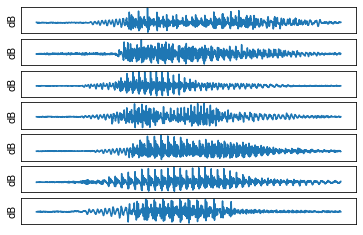

In [17]:
import os
wave, rate2 = librosa.load('so.wav', sr=16000) # 1 3 5 7 9 
mask2 = envelope(wave, 16000, 0.0005)
wave = wave[mask2]
wave_shape = wave.shape[0]
signal = wave.copy()
for i in range(wave_shape):
    if abs(signal[i]) < 0.05:
        signal[i] = 0
librosa.output.write_wav('data1/so_clean.wav', signal, sr=16000)

dau = []
cuoi = []
m = -1
m_dau = 0
print('signal_shape: ', wave_shape)

while(m != m_dau):
    m_dau = m
    for i in range(m+1, len(signal)):
        if sum(abs(signal[i:i+100])) > 10:
            for j in range(i+2000, len(signal)):
                if sum(signal[j:j+100]) == 0:
                    m = j + 1000
                    print('i la', i)
                    print('j la', j)
                    if sum(abs(signal[i-1000:j+2000])) > 100 and (j+1000-i+1000) > 1000:
                        dau.append(i-1500)
                        cuoi.append(j+2000)
                    break
            break
print('dau: ', dau)
print('cuoi: ', cuoi)


a = {}
    
for k in range(len(dau)):
    a[k] = wave[dau[k]:cuoi[k]]
    
    

for i in range(len(dau)):
    plt.subplot(len(dau),1,i+1)
    plt.plot(a[i])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('dB')

for n in a:
    out = np.array(n, dtype=np.float32)
n =[]
n1 = []
m = ['ba', 'bay', 'bon', 'hai', 'mot', 'nam', 'sau', 'tam']
for i in range(len(dau)):
    librosa.output.write_wav('data1/'+str(i)+'.wav', a[i], sr=16000)
    rate, wav = wavfile.read('data1/'+str(i)+'.wav') # 5388d14d.wav
    for i in range(0, wav.shape[0]-config.step, config.step):
        sample = wav[i:i+config.step]
        x = mfcc(sample, rate, numcep = config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        x = (x-config.min)/(config.max - config.min)
        x = x.reshape(1, x.shape[0], x.shape[1], 1)
        y_hat = model.predict(x)
    if np.max(y_hat) > 0.5:
        n.append(m[np.argmax(y_hat)])
        n1.append(np.max(y_hat))
print(n)
print(n1)


In [48]:
a = []
b= ['ba', 'bay', 'bon', 'hai', 'mot', 'nam', 'sau', 'tam']
for i in range(len(b)):
    a.append(b[i])
print(a)

['ba', 'bay', 'bon', 'hai', 'mot', 'nam', 'sau', 'tam']


In [28]:
print(fn_prob)

{'ec6afeb6.wav': array([2.4012965e-04, 9.9529869e-09, 7.7292143e-04, 1.6661335e-05,
       3.3581143e-04, 8.0236746e-03, 4.6538179e-07, 9.9057591e-01,
       6.3128333e-08, 3.4500004e-05], dtype=float32), '10da16fb.wav': array([9.6128792e-01, 3.6401847e-08, 1.7268570e-02, 6.4824586e-04,
       5.8758749e-05, 9.5308019e-04, 6.2758971e-08, 2.6612863e-04,
       1.6156881e-04, 1.9355606e-02], dtype=float32), 'bb1f5874.wav': array([9.6120781e-01, 2.8511879e-06, 2.4436744e-02, 1.4407046e-03,
       4.6746372e-03, 3.2505679e-03, 6.2125146e-06, 1.0680726e-03,
       1.3930746e-04, 3.7731852e-03], dtype=float32), 'c1c3c8b9.wav': array([1.4446860e-02, 4.7921685e-06, 3.2005737e-05, 7.0197752e-04,
       2.6858747e-02, 1.2087180e-02, 8.0255046e-07, 9.2038840e-01,
       8.2978985e-08, 2.5479198e-02], dtype=float32), 'c683f28f.wav': array([9.8236986e-03, 1.1586057e-08, 1.4938413e-05, 2.1800748e-03,
       6.1396738e-10, 9.8785305e-01, 6.2475893e-11, 3.6405083e-05,
       3.4445330e-10, 9.1944297e-

In [23]:
print(y)

['Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Saxophone', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Violin_or_fiddle', 'Hi-hat',

In [2]:
a = tqdm('VIVOSDEV12_248.wav')

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:41<?, ?it/s]


In [5]:
rate, wav  =wavfile.read('VIVOSDEV12_248.wav')

In [9]:
p_path = os.path.join('pickles', 'conv.p')
with open(p_path, 'rb') as handle:
    config = pickle.load(handle)

In [10]:
x = mfcc(wav, rate, numcep = config.nfeat, nfilt=config.nfilt, nfft=config.nfft)

In [11]:
x = (x-config.min)/(config.max - config.min)

In [12]:
x = x.reshape(1, x.shape[0], x.shape[1], 1)

In [16]:
model = load_model('models/conv.model')

In [17]:
y_hat = model.predict(x)
print(y_hat)

ValueError: Error when checking input: expected conv2d_1_input to have shape (9, 13, 1) but got array with shape (461, 13, 1)